## Pertubation of the apex edge-sampled domains

# Imports

In [1]:
import copy
import os
import random
import sys
print(sys.executable)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as sp
from scipy import spatial, sparse

import torch
import torch_scatter
#from torch_scatter import scatter
import torch_geometric.transforms as T


from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

from numba import njit

# Project-specific imports
from src import utils
from src.loader import load_graph
from src.utils import (largest_indices, cal_n_add_facni, 
                       extract_feat_adj2, calc_cad)
from classes import extract_all_features_single


/home/sucharitha/MintA/venv_minta/bin/python


# Routines

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import random

# Confidence Interval Calculation
def confid_measures(arr_tri, Num):
    arr_tri_mean = np.mean(arr_tri, axis=0)
    std = np.std(arr_tri, axis=0)
    Z = 1.960  # for 95% confidence
    upper = arr_tri_mean + Z * std / np.sqrt(Num)
    lower = arr_tri_mean - Z * std / np.sqrt(Num)
    return np.sort(arr_tri_mean), np.sort(lower), np.sort(upper)

# Eigenvector-based Solution Finder
def find_my_soln(WW):
    ATA = np.dot(WW, WW.T)
    w, v = np.linalg.eig(ATA)
    return v[:, 0]

# Flip Binary Bins
def flip_the_bins(x, lox):
    m = np.zeros_like(x)
    m[:, lox] = 1
    x_bol = np.array(x, dtype=bool)
    m_bol = np.array(m, dtype=bool)
    x2 = np.logical_xor(x_bol, m_bol)
    x2 = x2.astype(float)
    x2 = torch.from_numpy(x2)
    return x2

# Adversarial Node Predictions
def preds_of_adv(model0, data, adv_nodes_test):
    with torch.no_grad():
        model0.eval()
    pred_raw0 = model0(data.x_dict, data.edge_index_dict)
    y0_hat = pred_raw0.argmax(dim=-1)
    preds = y0_hat[adv_nodes_test]
    return preds

# Accuracy Calculation
def my_own_acc(a, b):
    acc = np.sum(np.equal(a, b)) / len(a)
    return acc

# Score Calculation
def my_score(pred, labels):
    accuracy = (pred == labels).sum() / len(pred)
    return accuracy

# Model Query
def model_qurey(model, data, idx_train):
    model.eval()
    pred_raw2 = model(data.x_dict, data.edge_index_dict)
    pred_raw2 = F.softmax(pred_raw2, dim=1)
    y2_hat = pred_raw2.argmax(dim=-1)
    labels_sur = y2_hat[idx_train]
    return labels_sur

# Random Binary Matrix Generator
def randbin(M, N, P):  
    return np.random.choice([0, 1], size=(M, N), p=[P, 1 - P])

# Feature Perturbation
def do_perturb_feat(x, m, scale=1.0):
    x_bol = np.array(x, dtype=bool)
    m_bol = np.array(m, dtype=bool)
    x2 = np.logical_xor(x_bol, m_bol)
    x2 = (x2 * scale).astype(float)
    x2 = torch.from_numpy(x2)
    return x2

# Adjacency Perturbation
def do_perturb_adj(a, m, scale=1.0):
    a_bol = np.array(a, dtype=bool)
    m_bol = np.array(m, dtype=bool)
    a2 = np.logical_xor(a_bol, m_bol)
    a2 = (a2 * scale).astype(float)
    a2 = torch.from_numpy(a2)
    return a2

# Adjacency Matrix to Edge Index
def A_to_edge_index(A):
    adj_t = torch.tensor(A)
    edge_index = adj_t.nonzero().t().contiguous()
    return edge_index

# Generate Adjacency Matrix from Edges
def edge_list_to_adj(adv_edge_lox1, adv_edge_lox2):
    elist = adv_edge_lox2
    domain_node_list = np.unique(elist)
    domain_node_list = domain_node_list[:4000]
    A = np.zeros((len(domain_node_list), len(domain_node_list)), dtype=int)
    for k in range(len(elist)):
        a = adv_edge_lox1[k]
        b = adv_edge_lox2[k]
        lox_a = np.where(domain_node_list == a)
        lox_b = np.where(domain_node_list == b)
        A[lox_a, lox_b] = 1
    return A

# Extract Adjacency Matrix
def extract_As_jan(data, adv_nodes):
    edge_list = data.edge_index_dict['domain_node', 'apex', 'domain_node']
    all_edges1 = edge_list[0, :].cpu()
    all_edges2 = edge_list[1, :].cpu()

    adv_edge_lox1 = np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2 = np.nonzero(np.in1d(all_edges2, adv_nodes))[0]
    L = len(adv_nodes)
    A_adv1 = np.zeros((L, L), dtype=int)
    adv_nodes = np.array(adv_nodes)

    for k in range(len(adv_edge_lox1)):
        a = all_edges1[adv_edge_lox1[k]]
        b = all_edges2[adv_edge_lox2[k]]
        lox_a = np.where(adv_nodes == a)
        lox_b = np.where(adv_nodes == b)
        A_adv1[lox_a, lox_b] = 1

    return A_adv1

# Extract Adjacency from Relations
def get_As_new(adj_1, adj_2, adj_3, adj_4, relation):
    domain_node_list = np.concatenate(
        (adj_1.cpu()[0], adj_2.cpu()[0], adj_3.cpu()[0], adj_4.cpu()[0]), axis=0
    )
    domain_node_list = np.unique(domain_node_list)
    test_mask = data['domain_node']['test_mask']
    xx_test = np.where(test_mask.cpu() > 0)
    domain_node_list_test = domain_node_list[xx_test]
    elist_test = []
    aaa = np.array(adj_2.cpu())
    for x in range(adj_2.shape[1]):
        innerlist = ((aaa[0, x], aaa[1, x]))
        if aaa[0, x] in domain_node_list_test:
            elist_test.append(innerlist)

    Atest = np.zeros((len(domain_node_list_test), len(domain_node_list_test)), dtype=int)
    for k in range(len(elist_test)):
        a = elist_test[k][0]
        b = elist_test[k][1]
        lox_a = np.where(domain_node_list_test == a)
        lox_b = np.where(domain_node_list_test == b)
        Atest[lox_a, lox_b] = 1

    return Atest

# Assign Adversary Nodes (NAS Malicious)
def assign_Adversary_nas_mal(data, norm_zero_int):
    test_mask = data['domain_node']['test_mask']
    labels_test = data['domain_node'].y[test_mask].cpu()
    lox_test = np.where(test_mask.cpu() > 0)[0]
    labels = data['domain_node'].y.cpu()
    lox_test_space = lox_test[np.where(labels_test.cpu() == 1)]  # Malicious nodes
    adv_nodes_test = random.sample(set(lox_test_space), norm_zero_int)
    return adv_nodes_test

# Assign Adversary Nodes (RAS)
def assign_Adversary_ras(data, norm_zero_int, seed=42):
    random.seed(seed)
    test_mask = data['domain_node']['test_mask']
    labels_test = data['domain_node'].y[test_mask].cpu()
    lox_test = np.where(test_mask.cpu() > 0)[0]
    labels = data['domain_node'].y.cpu()
    mal_nodes = lox_test[np.where(labels_test.cpu() == 1)]  # Malicious nodes

    if norm_zero_int > len(mal_nodes):
        norm_zero_int = len(mal_nodes)  # Limit to available malicious nodes

    adv_nodes_test = random.sample(set(mal_nodes), norm_zero_int)
    return adv_nodes_test

# Extract Adversarial Edges
def extract_A(data, adv_nodes):
    edge_list_1 = data.edge_index_dict['domain_node', 'apex', 'domain_node'][0, :]
    edge_list = data.edge_index_dict['domain_node', 'apex', 'domain_node']
    common_node_lox = np.nonzero(np.in1d(edge_list_1.cpu(), adv_nodes))[0]
    adv_edge_list = edge_list[:, common_node_lox]
    A_adv = edge_list_to_adj(adv_edge_list.cpu())
    return A_adv

# Calculate ASR
def calc_ASR(data, adv_nodes_test, model0):
    with torch.no_grad():
        model0.eval()
        pred_raw0 = model0(data.x_dict, data.edge_index_dict)
        pred_raw0 = F.softmax(pred_raw0, dim=1)
        y0_hat = pred_raw0.argmax(dim=-1)
        
    y0_hat = y0_hat[adv_nodes_test]

    with torch.no_grad():
        model0.eval()
        pred_raw2 = model0(data.x_dict2, data.edge_index_dict2)
        pred_raw2 = F.softmax(pred_raw2, dim=1)
        y2_hat = pred_raw2.argmax(dim=-1)
    y2_hat = y2_hat[adv_nodes_test]

    num_of_1 = (y0_hat == 1).sum().item()
    num_of_1_forced_to_0 = ((y0_hat == 1) & (y2_hat == 0)).sum().item()
    num_of_0 = (y0_hat == 0).sum().item()
    num_of_0_forced_to_1 = ((y0_hat == 0) & (y2_hat == 1)).sum().item()
    
    ASRgood = num_of_1_forced_to_0 / num_of_1 if num_of_1 > 0 else 0
    ASRbad = num_of_0_forced_to_1 / num_of_0 if num_of_0 > 0 else 0

    print("ASRgood", ASRgood, num_of_1_forced_to_0, num_of_1, "ASRbad", ASRbad, num_of_0_forced_to_1, num_of_0)
    return ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0


# Load datasets

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')

from src.loader2 import DNS2  # Assuming you have `DNS2` in `src.loader2`

# Function to dynamically create the dataset path
kg_path = lambda graph_name: f'/home/sucharitha/MintA/myGraph_datasets/{graph_name}'

# Load the dataset with transformations applied
dataset = DNS2(
    'myGraph_datasets/DNS',  # Updated dataset name for consistency with the original paper
    transform=T.Compose([T.NormalizeFeatures(), T.ToUndirected()]), 
    balance_gt=True  # Balance ground truth
)
data = dataset[0]

# Feature extraction and saving (commented, but can be used if needed)
# feats_2 = cal_n_add_facni(kg_path('DNS_eid_adv'), data)
# torch.save(feats_2, 'feats_2.pt')

# Another feature extraction process (commented, but can be used if needed)
# feats_new2 = cal_n_add_facni(kg_path('DNS_eid_adv'), data)
# torch.save(feats_new2, 'feats_new2.pt')

# Load precomputed features
feats_new2 = torch.load('feats_new2.pt')

# Assign features to domain, IP, and host nodes
data['domain_node'].x = feats_new2[0 : data.x_dict['domain_node'].shape[0], :]
data['ip_node'].x = torch.zeros(data['ip_node'].x.shape[0], 1)
data['host_node'].x = torch.zeros(data['host_node'].x.shape[0], 1)

# Clear memory for the loaded features
del feats_new2

# Print the current working directory for debugging
print(os.getcwd())

# Uncomment if metadata needs to be printed
# print(data.metadata)


/home/sucharitha/MintA


# The MDD model 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv, HeteroConv, Linear

class GraphTransformerNetwork(nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers, num_heads=4, dropout=0.3):
        super().__init__()
        
        # Create Transformer-based Heterogeneous Convolution Layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: TransformerConv(
                    in_channels=(-1, -1),  # Automatically infer input feature dimensions
                    out_channels=hidden_channels,
                    heads=num_heads,
                    dropout=dropout
                )
                for edge_type in metadata[1]  # Edge types from metadata
            })
            self.convs.append(conv)

        # Final linear layer for node-level prediction
        self.lin = Linear(hidden_channels * num_heads, out_channels)

    def forward(self, x_dict, edge_index_dict):
        # Pass through each convolution layer
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            # Apply Leaky ReLU activation to all node types
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        
        # Final output for 'domain_node'
        return self.lin(x_dict['domain_node'])

# Initialize the GTN model with adjusted parameters
model = GraphTransformerNetwork(
    metadata=data.metadata(),  # Metadata for heterogeneous graph
    hidden_channels=128,       # Increased hidden feature size
    out_channels=2,            # Number of output classes (binary classification)
    num_layers=3,              # Increased number of transformer layers
    num_heads=4,               # Increased attention heads for better representation
    dropout=0.3                # Increased dropout for regularization
)


In [5]:
import torch
import torch.nn.functional as F

# Check for available CUDA devices
print(torch.cuda.device_count())

# Set CUDA device and move data and model to the GPU
torch.cuda.set_device(0)  # Adjust the device ID as necessary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = model.to(device)

# Initialize lazy modules
with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)

# Define the optimizer with Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

# Training function
def train(model, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)  # Forward pass
    mask = data['domain_node'].train_mask
    loss = F.cross_entropy(out[mask], data['domain_node'].y[mask])  # Compute cross-entropy loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update model parameters
    return float(loss)

# Testing function
@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)  # Predicted classes
    accs = []  # List to store accuracy for train, validation, and test
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['domain_node'][split]  # Use the mask for the current split
        acc = (pred[mask] == data['domain_node'].y[mask]).sum() / mask.sum()  # Calculate accuracy
        accs.append(float(acc))
    return accs


1


# The surrogate

In [6]:
from torch_geometric.nn import TransformerConv
from torch_geometric.utils import dense_to_sparse  # To convert dense adjacency matrix to edge index
import torch.nn.functional as F
import numpy as np
import torch

# Extract data to train the surrogate model
train_mask = data['domain_node'].train_mask
labels_train = data['domain_node'].y.cpu()
labelled_labels_train_lox = np.where(labels_train < 2)
lox_train = np.where(train_mask.cpu() > 0)
lox_train = lox_train[0]

# Select training nodes and their features
labels = data['domain_node'].y.cpu()
lox_train_space = labelled_labels_train_lox
adv_nodes_train = lox_train_space[0][0:4000]  # Use the first 4000 nodes for training
Adj_sur = extract_As_jan(data, adv_nodes_train)  # Adjacency matrix for surrogate
features_sur = data['domain_node'].x[adv_nodes_train]

# Convert features_sur to a PyTorch tensor
if isinstance(features_sur, np.ndarray):  
    features_sur = torch.tensor(features_sur, dtype=torch.float32)
else:  
    features_sur = features_sur.float()

data.x_sur = features_sur  # Store features for surrogate training
idx_train = np.arange(4000)  # Training indices

# Ensure Adj_sur is a PyTorch tensor
if isinstance(Adj_sur, np.ndarray):  
    Adj_sur = torch.tensor(Adj_sur, dtype=torch.float32)
else:  
    Adj_sur = Adj_sur.float()

# Convert dense adjacency matrix (Adj_sur) to edge index format
edge_index_sur, _ = dense_to_sparse(Adj_sur)  # Convert to edge index format
edge_index_sur = edge_index_sur.to(torch.int64)  # Ensure integer type for edge index

# Define the simpler surrogate model
class SimpleSurrogateModel(torch.nn.Module):
    def __init__(self, in_features, hidden_features=16, out_features=2):
        super(SimpleSurrogateModel, self).__init__()
        self.conv1 = TransformerConv(
            in_channels=(-1, -1),  # Automatically infer input dimensions
            out_channels=hidden_features,
            heads=1,  # Single attention head for simplicity
            dropout=0.1  # Minimal dropout for less overfitting
        )
        self.fc = torch.nn.Linear(hidden_features, out_features)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)  # Use Leaky ReLU for smoother gradients
        return self.fc(x)

# Initialize the surrogate model
surrogate_model = SimpleSurrogateModel(
    in_features=features_sur.shape[1],
    hidden_features=16,  # Smaller hidden layer size for simplicity
    out_features=2       # Binary classification
).to(device)

# Prepare data for the surrogate model
x_sur = features_sur.to(device)  # Move features to the correct device


# The proposed MinstA

In [11]:
def one_trial():   
    # Load dataset and preprocess features
    dataset = DNS2('myGraph_datasets/DNS', transform=T.Compose([T.NormalizeFeatures(), T.ToUndirected()]), balance_gt=True)
    data = dataset[0]
    feats_new = torch.load('feats_new2.pt')
    data['domain_node'].x = feats_new[0:data.x_dict['domain_node'].shape[0], :]
    data['ip_node'].x = torch.zeros(data['ip_node'].x.shape[0], 1)
    data['host_node'].x = torch.zeros(data['host_node'].x.shape[0], 1)
    del feats_new

    # Extract adjacency matrices
    feat_node, feat_ip, adj_1, adj_2, adj_3, adj_4, adj_5, adj_6 = extract_feat_adj2(data)
    relation = 2
    Atest = get_As_new(adj_1, adj_2, adj_3, adj_4, relation)

    x = data['domain_node'].x.cpu()
    adv_nodes_test = assign_Adversary_ras(data, 100)
    A_adv = extract_As_jan(data, adv_nodes_test)

    perf_arr = np.empty((7, 0))  # Adjusted to match original output dimensions
    val_nodes = np.array([1, 5, 20, 40, 60, 80, 100])

    # Initialize and train the main Graph Transformer Network
    model0 = GraphTransformerNetwork(
        metadata=data.metadata(), 
        hidden_channels=128,  # Adjusted hidden size for main GTN
        out_channels=2, 
        num_layers=3,         # Increased transformer layers
        num_heads=4,          # Optimized attention heads
        dropout=0.2           # Moderate dropout
    )
    data, model0 = data.to(device), model0.to(device)
    data.x_dict2 = copy.deepcopy(data.x_dict)
    data.edge_index_dict2 = copy.deepcopy(data.edge_index_dict)

    optimizer = torch.optim.Adam(model0.parameters(), lr=0.005, weight_decay=1e-4)

    # Training the main GTN
    for epoch in range(201):
        loss = train(model0, data, optimizer)

    labels_sur = model_qurey(model0, data, idx_train)
    labels_sur = np.array(labels_sur.cpu())

    preds = preds_of_adv(model0, data, adv_nodes_test)

    # Train the surrogate model (SimpleSurrogateModel)
    features_sur = data['domain_node'].x[adv_nodes_test]
    features_sur = torch.tensor(features_sur.cpu().numpy(), dtype=torch.float32).to("cpu")  # Move to CPU
    Adj_sur = extract_As_jan(data, adv_nodes_test)
    edge_index_sur, _ = dense_to_sparse(torch.tensor(Adj_sur, dtype=torch.float32).to("cpu"))  # Ensure tensor is on CPU

    surrogate = SimpleSurrogateModel(
        in_features=features_sur.shape[1], 
        hidden_features=16,   # Smaller hidden size for surrogate
        out_features=2
    ).to("cpu")  # Run surrogate on CPU to save GPU memory

    optimizer_surrogate = torch.optim.Adam(surrogate.parameters(), lr=0.001, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    surrogate.train()
    for epoch in range(100):  # Simplified training for surrogate
        optimizer_surrogate.zero_grad()
        out_surrogate = surrogate(features_sur, edge_index_sur)
        loss = loss_fn(out_surrogate[idx_train], torch.tensor(labels_sur[idx_train], dtype=torch.long))
        loss.backward()
        optimizer_surrogate.step()

    for val in val_nodes:
        print(val)
        temp0 = data.edge_index_dict2[('domain_node', 'apex', 'domain_node')]
        temp0 = np.array(temp0.cpu())
        node_list0 = temp0[0, :]
        X = x[adv_nodes_test, :].cpu()
        X = torch.tensor(np.array(X), dtype=torch.float32).to("cpu")
        A = torch.tensor(np.array(A_adv), dtype=torch.float32).to("cpu")
        X2 = copy.deepcopy(X)
        w1 = surrogate.fc
        W = w1.weight.data
        W1 = np.array(W.cpu())
        F1 = find_my_soln(W1)
        simi_arr = np.zeros([100, 100])
        messages = np.dot(A.cpu().numpy(), X2.cpu().numpy())
        for i in range(100):
            tempx = A[i, :]
            js = np.flatnonzero(tempx.cpu().numpy())
            for j in range(100):
                W2 = copy.deepcopy(W1)
                d_j = len(js)
                F2 = 0 * F1
                for kk in np.arange(len(js)):
                    message_j = messages[js[kk], :]
                for kkk in np.arange(16):  # Match hidden features of surrogate
                    if d_j > 0:
                        W2[:, kkk] = W1[:, kkk] - 1 / d_j * message_j

                F2 = F2 + find_my_soln(W2)
                simi_arr[i, j] = np.linalg.norm(F1 + F2)

        largest_idx = largest_indices(simi_arr, val * val)
        largest_idx = np.array(largest_idx)

        m = np.zeros([100, 100])
        for i in range(largest_idx.shape[1]):
            m[largest_idx[0, i], largest_idx[1, i]] = 1
        A2 = do_perturb_adj(A.cpu().numpy(), m)

        aa = A_to_edge_index(torch.tensor(A2, dtype=torch.int64))

        conv = np.zeros_like(aa)
        for k in range(aa.shape[1]):
            conv[0, k] = adv_nodes_test[aa[0, k]]
            conv[1, k] = adv_nodes_test[aa[1, k]]

        all_edges = temp0
        adv_edge_lox = np.nonzero(np.in1d(all_edges[0, :], adv_nodes_test))[0]
        non_adv_edges = np.delete(all_edges, adv_edge_lox, axis=1)
        temp2 = np.hstack((non_adv_edges, conv))
        temp2 = torch.tensor(temp2, dtype=torch.int64).to(device)
        data.edge_index_dict2[('domain_node', 'apex', 'domain_node')] = temp2
        data = data.to(device)
        ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0 = calc_ASR(data, adv_nodes_test, model0)

        temp = np.array([ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0]).reshape(-1, 1)
        perf_arr = np.hstack((perf_arr, temp))

    return perf_arr


In [12]:
Num = 30  # Number of trials
res_arr = np.zeros((Num, 7, 7))  # Initialize result array for ASR and NFR metrics

for tri in range(Num):
    print(f"Running trial {tri + 1}/{Num}")
    try:
        g1 = one_trial()  # Execute one trial
        res_arr[tri, :, :] = g1  # Store results for this trial
    except Exception as e:
        print(f"Error in trial {tri + 1}: {e}")
        continue

Running trial 1/30
Error in trial 1: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Running trial 2/30
Error in trial 2: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Running trial 3/30


KeyboardInterrupt: 

In [9]:
arr1 = np.mean(res_arr, axis = 0)
avg_mal_num=arr1[:,2].mean()
avg_ben_num=arr1[:,5].mean()

In [10]:
val_nodes=np.array([1,5,20,40,60,80,100])


# Plot results

In [11]:
plt.rcParams['font.size'] = 17
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

## Plot ASR

Shape of arr_tri: (30, 7)
Shape of arr_tri_mean: (7,)
Sorted mean: [0.05679248 0.07089141 0.08975224 0.09553928 0.09759259 0.12711793
 0.13127743]
Sorted lower: [-3.29656587e-03 -2.99377585e-04  2.37360772e-05  1.50181119e-02
  2.03333170e-02  2.44156683e-02  2.74413627e-02]
Sorted upper: [0.09856685 0.11736714 0.18280104 0.19105482 0.19548456 0.23390254
 0.23511349]


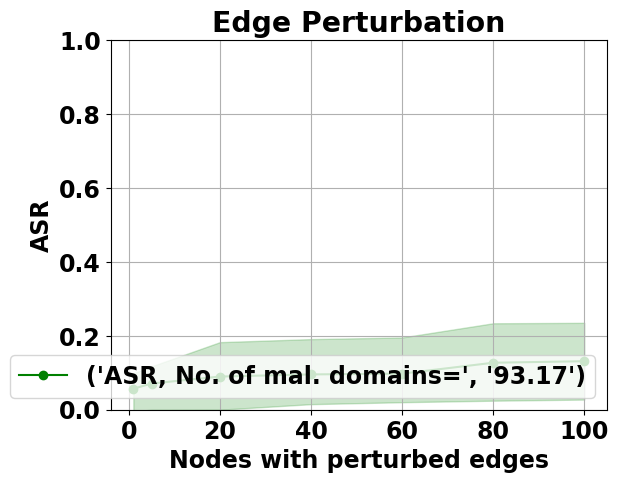

In [12]:
num_change_arr=val_nodes
if not os.path.exists('RESULTS_adj2_sampled_doms'):
    os.makedirs('RESULTS_adj2_sampled_doms')
plt.figure(facecolor='white')
plt.title("Edge Perturbation")
plt.xlabel("Nodes with perturbed edges") 
plt.ylabel("ASR") 

# plot the ASR:
m0, l0, u0=confid_measures(res_arr[:,0,:], Num)
plt.plot(val_nodes, m0,'-og', label=("ASR, No. of mal. domains=", '%.2f' % 93.17))
plt.fill_between(num_change_arr, l0, u0, color='green', alpha=0.2)
plt.ylim(0, 1)
plt.grid()
plt.legend(loc='lower right')
plt.grid()
plt.legend(loc='lower right')
plt.grid()
name='RESULTS_adj2_sampled_doms/asr_plot1_'+ str(Num)+'_trials_ras.png'
plt.savefig(name, dpi=150) 
name='RESULTS_adj2_sampled_doms/asr_plot1_'+ str(Num)+'_trials_ras.pdf'
plt.savefig(name, dpi=150) 
plt.show()


## Plot NFR

Shape of arr_tri: (30, 7)
Shape of arr_tri_mean: (7,)
Sorted mean: [2.33333333 2.36666667 2.56666667 2.6        3.36666667 4.03333333
 5.        ]
Sorted lower: [-0.29682363 -0.2169985  -0.19119415  0.48304121  0.78650917  0.86899033
  1.2872937 ]
Sorted upper: [3.94682416 4.96349029 5.35033183 5.39119415 5.44603963 7.58362546
 9.13100967]


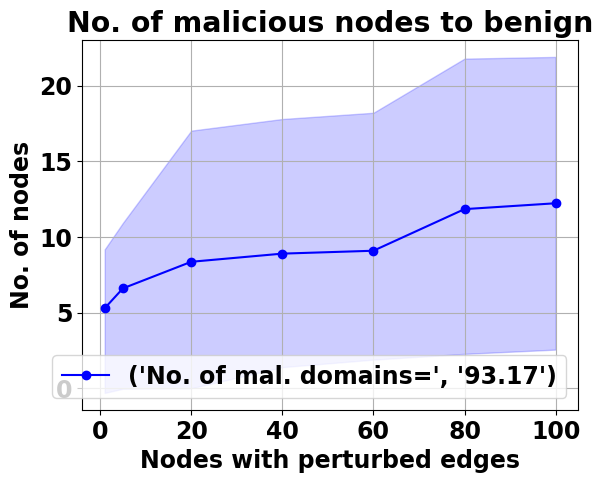

Shape of arr_tri: (30, 7)
Shape of arr_tri_mean: (7,)
Sorted mean: [2.33333333 2.36666667 2.56666667 2.6        3.36666667 4.03333333
 5.        ]
Sorted lower: [-0.29682363 -0.2169985  -0.19119415  0.48304121  0.78650917  0.86899033
  1.2872937 ]
Sorted upper: [3.94682416 4.96349029 5.35033183 5.39119415 5.44603963 7.58362546
 9.13100967]


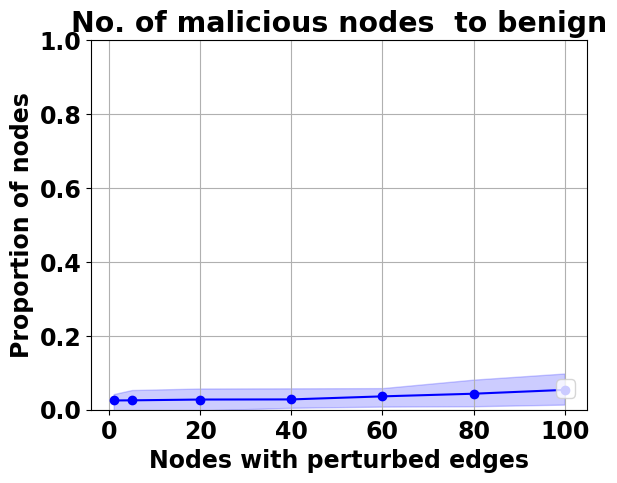

In [13]:

m1, l1, u1 = confid_measures(res_arr[:, 1, :], Num)

plt.figure(facecolor='white')
plt.title("No. of malicious nodes to benign")
plt.xlabel("Nodes with perturbed edges")
plt.ylabel("No. of nodes")


plt.plot(val_nodes, m0*93.17, '-ob', label=("No. of mal. domains=", '%.2f' % 93.17))
plt.fill_between(val_nodes, l0*93.17, u0*93.17, color='blue', alpha=0.2)

plt.legend(loc='lower right')
plt.grid()

# Save plots
name = f'RESULTS_adj2_sampled_doms/nfr_plot_{Num}_trials_ras.png'
plt.savefig(name, dpi=150)
name = f'RESULTS_adj2_sampled_doms/nfr_plot_{Num}_trials_ras.pdf'
plt.savefig(name, dpi=150)

plt.show()


m1, l1, u1 = confid_measures(res_arr[:, 1, :], Num)

# Normalize NFR values
m1_normalized = m1 / 93.17  # Mean normalized by total malicious nodes
l1_normalized = l1 / 93.17  # Lower bound normalized
u1_normalized = u1 / 93.17  # Upper bound normalized

# Plot with normalized y-axis
plt.figure(facecolor='white')
plt.title("No. of malicious nodes  to benign")
plt.xlabel("Nodes with perturbed edges")
plt.ylabel("Proportion of nodes")

# Plot the normalized NFR with confidence intervals
plt.fill_between(val_nodes, l1_normalized, u1_normalized, color='blue', alpha=0.2)
plt.plot(val_nodes, m1_normalized, '-ob')

# Set the y-axis range to match the normalized scale
plt.ylim(0, 1)

# Add grid and legend
plt.legend(loc='lower right')
plt.grid()

# Save the plot
plt.savefig('RESULTS_adj2_sampled_doms/nfr_normalized_plot.png', dpi=150)
plt.savefig('RESULTS_adj2_sampled_doms/nfr_normalized_plot.pdf', dpi=150)

# Show the plot
plt.show()



## Plot ROC

arr1 shape: (6, 7)
Shape of arr_tri: (1, 7)
Shape of arr_tri_mean: (7,)
Sorted mean: [0.07138187 0.08058133 0.17466246 0.19354497 0.19616186 0.2014356
 0.20149258]
Sorted lower: [0.07138187 0.08058133 0.17466246 0.19354497 0.19616186 0.2014356
 0.20149258]
Sorted upper: [0.07138187 0.08058133 0.17466246 0.19354497 0.19616186 0.2014356
 0.20149258]
Computed FPR (m3): [0.07138187 0.08058133 0.17466246 0.19354497 0.19616186 0.2014356
 0.20149258]


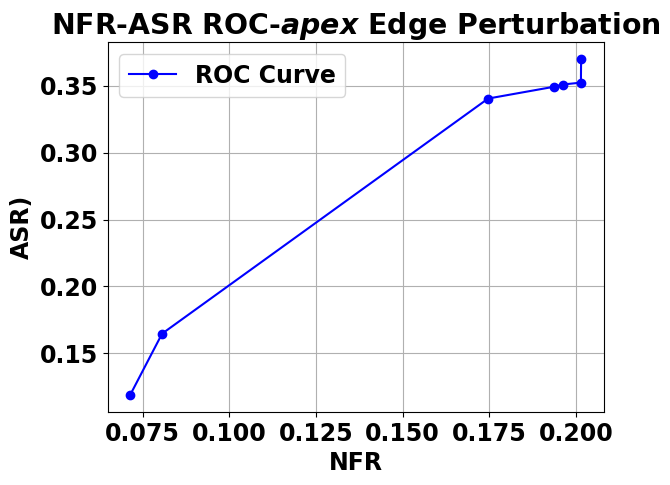

In [42]:
# Verify the shape of arr1
print("arr1 shape:", arr1.shape)

# Extract FPR values (3rd metric)
try:
    fpr_values = arr1[3, :]  # 3rd metric corresponds to FPR
    m3, l3, u3 = confid_measures(fpr_values.reshape(1, -1), 100)
    print("Computed FPR (m3):", m3)
except Exception as e:
    print("Error calculating m3 (FPR):", e)
    m3 = np.zeros_like(fpr_values)  # Fallback to zero array
    l3 = np.zeros_like(fpr_values)
    u3 = np.zeros_like(fpr_values)

# Assign TPR (ASR mean values) and FPR (FPR mean values)
tpr = m0  # True Positive Rate
fpr = m3  # False Positive Rate

# Plot the ROC Curve
plt.figure(facecolor='white')
plt.title("NFR-ASR ROC-$\it{apex}$ Edge Perturbation")
plt.xlabel("NFR") 
plt.ylabel("ASR)") 
plt.plot(fpr, tpr, '-ob', label="ROC Curve")  # Plot FPR vs. TPR
plt.legend()
plt.grid()

# Save the plot
name = 'RESULTS_adj2_sampled_doms/asr_plot3_' + str(Num) + '_ROC.png'
plt.savefig(name, dpi=150)
name = 'RESULTS_adj2_sampled_doms/asr_plot3_' + str(Num) + '_ROC.pdf'
plt.savefig(name, dpi=150)

# Show the plot
plt.show()
